<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Описание-проекта" data-toc-modified-id="Описание-проекта-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Описание проекта</a></span></li><li><span><a href="#Загрузка-данных" data-toc-modified-id="Загрузка-данных-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Загрузка данных</a></span></li><li><span><a href="#Масштабирование" data-toc-modified-id="Масштабирование-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Масштабирование</a></span></li><li><span><a href="#Двухэтапная-модель-FAISS+CatBoost" data-toc-modified-id="Двухэтапная-модель-FAISS+CatBoost-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Двухэтапная модель FAISS+CatBoost</a></span><ul class="toc-item"><li><span><a href="#Создание-индексов" data-toc-modified-id="Создание-индексов-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Создание индексов</a></span></li><li><span><a href="#Отбор-кандидатов-FAISS" data-toc-modified-id="Отбор-кандидатов-FAISS-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Отбор кандидатов FAISS</a></span><ul class="toc-item"><li><span><a href="#Объединим-кандидатов-в-DataFrame" data-toc-modified-id="Объединим-кандидатов-в-DataFrame-4.2.1"><span class="toc-item-num">4.2.1&nbsp;&nbsp;</span>Объединим кандидатов в DataFrame</a></span></li><li><span><a href="#Добавим-признаки" data-toc-modified-id="Добавим-признаки-4.2.2"><span class="toc-item-num">4.2.2&nbsp;&nbsp;</span>Добавим признаки</a></span></li></ul></li><li><span><a href="#Формирование-датасетов-для-обучения-катбуста" data-toc-modified-id="Формирование-датасетов-для-обучения-катбуста-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>Формирование датасетов для обучения катбуста</a></span><ul class="toc-item"><li><span><a href="#Добавим-новые-признаки" data-toc-modified-id="Добавим-новые-признаки-4.3.1"><span class="toc-item-num">4.3.1&nbsp;&nbsp;</span>Добавим новые признаки</a></span></li></ul></li><li><span><a href="#Обучение-CatBoostClassifier" data-toc-modified-id="Обучение-CatBoostClassifier-4.4"><span class="toc-item-num">4.4&nbsp;&nbsp;</span>Обучение CatBoostClassifier</a></span></li><li><span><a href="#Важность-признаков" data-toc-modified-id="Важность-признаков-4.5"><span class="toc-item-num">4.5&nbsp;&nbsp;</span>Важность признаков</a></span></li><li><span><a href="#Тест-на-validation" data-toc-modified-id="Тест-на-validation-4.6"><span class="toc-item-num">4.6&nbsp;&nbsp;</span>Тест на validation</a></span><ul class="toc-item"><li><span><a href="#Отбор-кандидатов-FAISS" data-toc-modified-id="Отбор-кандидатов-FAISS-4.6.1"><span class="toc-item-num">4.6.1&nbsp;&nbsp;</span>Отбор кандидатов FAISS</a></span></li><li><span><a href="#Объединим-кандидатов-в-DataFrame" data-toc-modified-id="Объединим-кандидатов-в-DataFrame-4.6.2"><span class="toc-item-num">4.6.2&nbsp;&nbsp;</span>Объединим кандидатов в DataFrame</a></span></li><li><span><a href="#Добавим-признаки" data-toc-modified-id="Добавим-признаки-4.6.3"><span class="toc-item-num">4.6.3&nbsp;&nbsp;</span>Добавим признаки</a></span></li><li><span><a href="#Ранжирование" data-toc-modified-id="Ранжирование-4.6.4"><span class="toc-item-num">4.6.4&nbsp;&nbsp;</span>Ранжирование</a></span></li><li><span><a href="#Расчет-метрики" data-toc-modified-id="Расчет-метрики-4.6.5"><span class="toc-item-num">4.6.5&nbsp;&nbsp;</span>Расчет метрики</a></span></li></ul></li></ul></li><li><span><a href="#Выводы:" data-toc-modified-id="Выводы:-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Выводы:</a></span></li></ul></div>

# Matching

## Описание проекта

Есть реальные данные от одного из крупнейших маркетплейсов страны. Для каждого товара уже сформированы числовые векторы размерностью 72. Всего, наборов для обучения ~ 3 млн. 

**Цель:** разработать модель для поиска товаров, с высоким значением метрики accuracy@5 (не меньше 80%) 

**Задачи:**

- разработать алгоритм, который для всех товаров из validation.csv предложит несколько вариантов наиболее похожих товаров из base;
- оценить качество алгоритма по метрике accuracy@5.


**Стэк:** FAISS, KNN, ранжирующие модели, индексирование в векторных базах

## Загрузка данных

In [1]:
#conda install -c conda-forge faiss

In [2]:
import pandas as pd
import numpy as np
import faiss
import phik

from catboost import CatBoostClassifier
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt

import time
from tqdm import tqdm

import warnings
warnings.filterwarnings("ignore")

In [3]:
path='C:/Users/zoika/OneDrive/Рабочий стол/YP ds54/Practika/Mathing/'

In [4]:
base = pd.read_csv(path+'base.csv',index_col=0).astype(np.float16)
display(base.shape)
base.head(1)

(2918139, 72)

,0,1,2,3,4,5,6,7,8,9,...,62,63,64,65,66,67,68,69,70,71
Id,,,,,,,,,,,,,,,,,,,,,
0-base,-115.0625,11.15625,-64.4375,-118.875,216.5,-104.6875,-469.0,44.34375,120.9375,181.5,...,-42.8125,38.8125,-151.75,-74.375,63.65625,-4.703125,92.9375,115.25,-112.75,-60.84375


In [5]:
train = pd.read_csv(path+'train.csv',index_col=0)
train.loc[:,'0':'71'].astype(np.float16)
display(train.shape)
train.head(1)

(100000, 73)

,0,1,2,3,4,5,6,7,8,9,...,63,64,65,66,67,68,69,70,71,Target
Id,,,,,,,,,,,,,,,,,,,,,
0-query,-53.882748,17.971436,-42.117104,-183.93668,187.51749,-87.14493,-347.360606,38.307602,109.08556,30.413513,...,70.10736,-155.80257,-101.965943,65.90379,34.4575,62.642094,134.7636,-415.750254,-25.958572,675816-base


## Масштабирование

In [6]:
features=train.copy().drop(['Target'] ,axis=1) 
targets=train["Target"].copy()

In [7]:
scaler = StandardScaler()
base[:]=scaler.fit_transform(base[:]) 
base.head(2)

,0,1,2,3,4,5,6,7,8,9,...,62,63,64,65,66,67,68,69,70,71
Id,,,,,,,,,,,,,,,,,,,,,
0-base,-1.158203,0.621094,-0.51416,1.399414,2.269531,-1.160156,-0.282715,0.373535,-0.432129,0.885254,...,1.189453,0.190918,0.073914,-0.894531,-2.269531,-0.510254,0.293213,-0.014954,1.782227,-0.312744
1-base,2.076172,1.060547,-0.65332,-1.000977,-1.157227,-0.501465,1.130859,-0.871582,-0.628906,1.098633,...,-1.271484,0.270020,-0.074646,-1.096680,0.217041,0.014435,1.712891,0.058838,1.854492,-0.281250


In [8]:
features[:]=scaler.transform(features[:])
features.head(2)

,0,1,2,3,4,5,6,7,8,9,...,62,63,64,65,66,67,68,69,70,71
Id,,,,,,,,,,,,,,,,,,,,,
0-query,1.299521,1.996883,0.063773,-1.879674,1.644099,-0.537624,0.165088,0.279598,-2.296794,-1.459627,...,-0.866976,1.274320,-0.024409,-1.173479,-1.035366,0.197183,-0.200787,0.906574,0.995119,0.522965
1-query,-0.062145,-0.257161,0.324248,-1.543249,0.204684,-0.419327,1.095707,-1.538328,0.193790,0.246358,...,1.254598,-0.991074,0.075152,-0.159575,0.207978,0.028030,0.244772,0.709458,-0.612417,-0.083489


## Двухэтапная модель FAISS+CatBoost
Отберем кандидатов с помощью FAISS, затем ранжируем их помощью CatBoostClassifier и оставим топ-5 для расчета метрик.

**Гипотеза 1:** Двухэтапная модель FAISS+CatBoost (от 100 кандидатов на 1м этапе) даст не менее 75% точности

### Создание индексов

In [9]:
%%time 
dims = base.shape[1]   # размерность вектора признаков
n_cells =   512        # кол-во центроидов/кластеров для группировки                
quantizer = faiss.IndexFlatL2(dims)
idx_l2 = faiss.IndexIVFFlat(quantizer, dims, n_cells)

idx_l2.train(np.ascontiguousarray(base.values[:100000, :]).astype('float16')) 
idx_l2.add(np.ascontiguousarray(base.values).astype('float16'))

CPU times: total: 21min 27s
Wall time: 2min 46s


### Отбор кандидатов FAISS 

In [10]:
%%time 
idx_l2.nprobe=256  # Проходим по топ-nprobe центроид для поиска top-k ближайших соседей
k=100 #сколько ближайших соседей искать для каждого товара
vecs, idx = idx_l2.search(np.ascontiguousarray(features.values).astype('float16'), k)  

CPU times: total: 4h 34min 11s
Wall time: 24min 42s


In [11]:
base_index = {k: v for k, v in enumerate(base.index.to_list())}

In [12]:
acc = 0
for target, el in tqdm(zip(targets.values.tolist(), idx.tolist())):
    acc += int(target in [base_index[r] for r in el])

print(100 * acc / len(idx))

100000it [00:03, 28437.81it/s]


79.034


#### Объединим кандидатов в DataFrame

In [14]:
def con_candidate(i,l,lnew,validation):
    for j in range(len(l)):
        lnew.append([validation.index[i],base_index[l[j]] ,j ])
    return lnew

In [15]:
lnew=[]
for i in tqdm(range(len(idx))):    
    lnew=con_candidate(i,idx[i],lnew,train)

df_t_new=pd.DataFrame(data=lnew,columns=['id_name','id_cand_name','rank'])
display(df_t_new.shape)
df_t_new.head(4)

100%|██████████| 100000/100000 [00:11<00:00, 8596.15it/s]


(10000000, 3)

,id_name,id_cand_name,rank
0,0-query,675816-base,0
1,0-query,877519-base,1
2,0-query,361564-base,2
3,0-query,2725256-base,3


In [16]:
del lnew

#### Добавим признаки

Добавим целевой признак.
Заполним колонку **"ground truth"**, где будет 1 - если товар-кандидат совпал с товаром, отмеченным экспертом, и 0 - в противном случае
Эта колонка будет целевым признаком при обучении катбуста

In [17]:
%%time
#присоединим 'Target':  
df=pd.merge(df_t_new, train[['Target']], how='left', left_on='id_name', right_on=train.index).copy() 

df['ground truth']=(df["id_cand_name"]==df["Target"])
df['ground truth']=df['ground truth'].apply(lambda x: int(x))   
df=df.drop(['Target'],axis=1)
df.head(2)

CPU times: total: 7.86 s
Wall time: 7.86 s


,id_name,id_cand_name,rank,ground truth
0,0-query,675816-base,0,1
1,0-query,877519-base,1,0


 Добавим признаки товарам

In [18]:
#присоединим хар-ки основного товара:
df=pd.merge(df, features, how='left', left_on='id_name', right_on=features.index)  

#присоединим хар-ки кандидатов
df=pd.merge(df, base.add_suffix('_cand'), how='left', left_on='id_cand_name', right_on=base.index)
df.head(2)

,id_name,id_cand_name,rank,ground truth,0,1,2,3,4,5,...,62_cand,63_cand,64_cand,65_cand,66_cand,67_cand,68_cand,69_cand,70_cand,71_cand
0,0-query,675816-base,0,1,1.299521,1.996883,0.063773,-1.879674,1.644099,-0.537624,...,-0.927246,1.626953,0.073914,0.427246,-0.502441,0.395020,-0.568359,0.067688,0.995605,0.708984
1,0-query,877519-base,1,0,1.299521,1.996883,0.063773,-1.879674,1.644099,-0.537624,...,-0.676758,1.614258,-0.247437,-0.404297,-1.153320,0.412598,-0.375732,0.728516,0.543945,0.270508


### Формирование датасетов для обучения катбуста

#### Добавим новые признаки
Как разности между важными признаками (важность определили в прошлой версии ноутбука с помощью .get_feature_importance() модели катбуста )

In [19]:
df['abs70']=abs(df['70']-df['70_cand'])
df['abs33']=abs(df['33']-df['33_cand'])
df['abs6']=abs(df['6']-df['6_cand'])
df['abs44']=abs(df['44']-df['44_cand'])
df['abs21']=abs(df['21']-df['21_cand'])

In [20]:
df_mini=df.loc[:,'id_name':].copy()
display(df_mini.shape)
df_mini.head(1)

(10000000, 153)

,id_name,id_cand_name,rank,ground truth,0,1,2,3,4,5,...,67_cand,68_cand,69_cand,70_cand,71_cand,abs70,abs33,abs6,abs44,abs21
0,0-query,675816-base,0,1,1.299521,1.996883,0.063773,-1.879674,1.644099,-0.537624,...,0.39502,-0.568359,0.067688,0.995605,0.708984,0.000486,0.567362,0.000439,0.180287,1.521696


In [21]:
feat_col=df_mini.columns.to_list()  #список колонок с признаками, для катбуста
feat_col=feat_col[2:]
feat_col.remove('ground truth')
len(feat_col)

150

In [22]:
features_train_m=df_mini[:9000000].copy()
features_test_m=df_mini[9000000:10000000].copy()
print(features_train_m.shape, ';', features_test_m.shape)

(9000000, 153) ; (1000000, 153)


In [23]:
features_train_m[feat_col].head(4)

,rank,0,1,2,3,4,5,6,7,8,...,67_cand,68_cand,69_cand,70_cand,71_cand,abs70,abs33,abs6,abs44,abs21
0,0,1.299521,1.996883,0.063773,-1.879674,1.644099,-0.537624,0.165088,0.279598,-2.296794,...,0.395020,-0.568359,0.067688,0.995605,0.708984,0.000486,0.567362,0.000439,0.180287,1.521696
1,1,1.299521,1.996883,0.063773,-1.879674,1.644099,-0.537624,0.165088,0.279598,-2.296794,...,0.412598,-0.375732,0.728516,0.543945,0.270508,0.451174,0.000509,0.837940,0.000377,0.915804
2,2,1.299521,1.996883,0.063773,-1.879674,1.644099,-0.537624,0.165088,0.279598,-2.296794,...,0.281006,-0.491943,0.530762,0.542969,0.090088,0.452150,0.424337,1.516651,0.180287,1.521696
3,3,1.299521,1.996883,0.063773,-1.879674,1.644099,-0.537624,0.165088,0.279598,-2.296794,...,0.156128,-1.269531,0.008652,1.964844,0.834473,0.969725,0.163065,0.057605,0.180287,0.226351


### Обучение CatBoostClassifier 

Используем CatBoostClassifier для ранжирования кандидатов.В качестве ранга возьмем вероятность принадлежности к классу 1, запишем ее в колонку "cb_proba".

Так как, выборка получилась сильно несбалансированная, при обучении используем аргумент class_weights. Соотношение возьмем пропорционально числу кандидатов, так как верный - максимум один из всех

In [24]:
target_mini=df_mini[['ground truth']].copy()
target_train_m=target_mini[:9000000].copy()
target_test_m=target_mini[9000000:10000000].copy()
print(target_train_m.shape, ';', features_test_m.shape)

(9000000, 1) ; (1000000, 153)


In [25]:
%%time

model = CatBoostClassifier(iterations=800,learning_rate=0.1, class_weights=(1, k-1))  #k - ckolko candidatov learning_rate=0.1,

model.fit(features_train_m[feat_col],
          target_train_m,
          eval_set=(features_test_m[feat_col],target_test_m),
          early_stopping_rounds=25,
          plot=True,
          verbose=100)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.4990079	test: 0.4990912	best: 0.4990912 (0)	total: 1.79s	remaining: 23m 50s
100:	learn: 0.0671744	test: 0.0699216	best: 0.0699216 (100)	total: 2m 43s	remaining: 18m 50s
200:	learn: 0.0602967	test: 0.0651805	best: 0.0651805 (200)	total: 5m 22s	remaining: 16m 2s
300:	learn: 0.0555116	test: 0.0626929	best: 0.0626929 (300)	total: 8m 2s	remaining: 13m 19s
400:	learn: 0.0518829	test: 0.0612797	best: 0.0612739 (399)	total: 10m 29s	remaining: 10m 26s
500:	learn: 0.0487634	test: 0.0603761	best: 0.0603761 (500)	total: 13m 2s	remaining: 7m 47s
600:	learn: 0.0460655	test: 0.0599478	best: 0.0599478 (600)	total: 15m 26s	remaining: 5m 6s
700:	learn: 0.0436631	test: 0.0594774	best: 0.0594678 (698)	total: 17m 50s	remaining: 2m 31s
Stopped by overfitting detector  (25 iterations wait)

bestTest = 0.05945994004
bestIteration = 717

Shrink model to first 718 iterations.
CPU times: total: 3h 30min 22s
Wall time: 22min 12s


In [26]:
#model.save_model('model_cb_0059.json')
#model.save_model('model_cb_0059.bin')

### Важность признаков

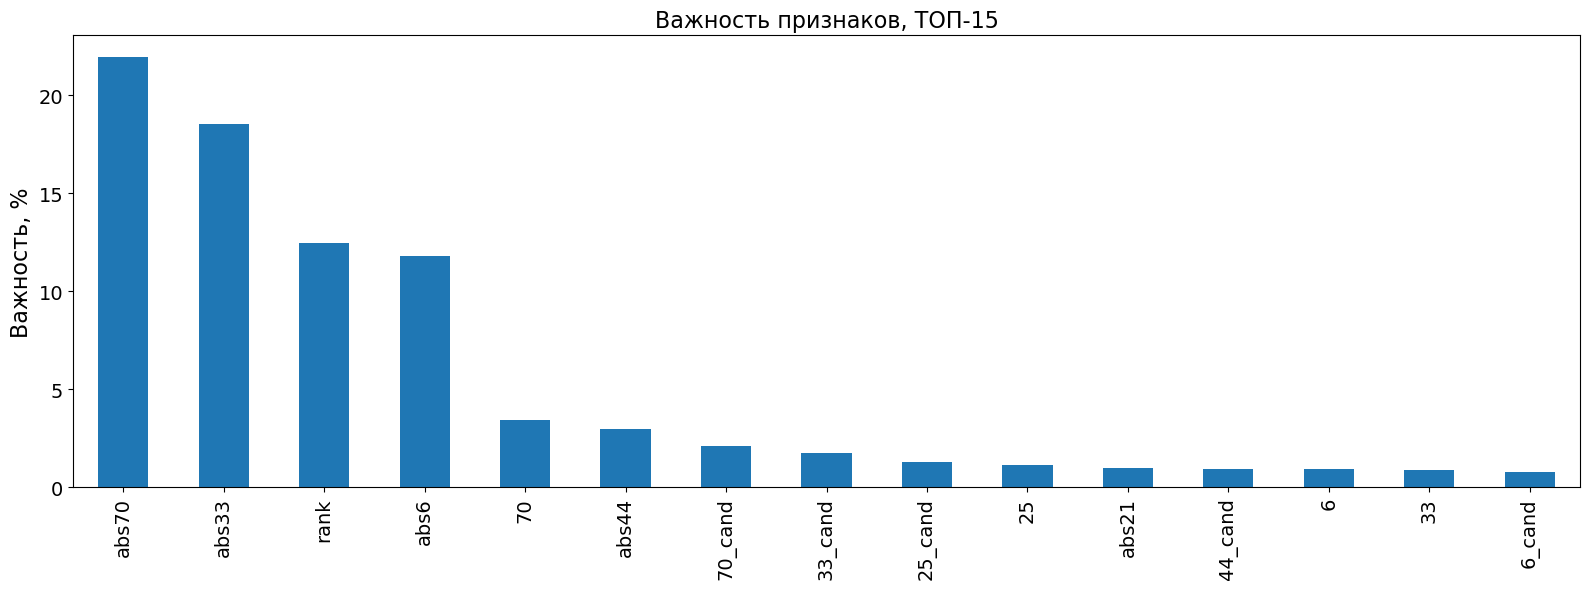

In [27]:
fi = pd.Series(model.get_feature_importance(),feat_col)          
fig, ax = plt.subplots(figsize=(16,6))
fi.sort_values(ascending=False).head(15).plot.bar(ax=ax,fontsize=14)
ax.set_title("Важность признаков, ТОП-15", fontsize=16)
ax.set_ylabel('Важность, %', fontsize=16)
fig.tight_layout( )

In [28]:
#0.05902260421 600 015

### Тест на validation

In [29]:
validation = pd.read_csv(path+'validation.csv',index_col=0)
validation=validation.astype(np.float16)
display(validation.shape)
validation.head(1)

(100000, 72)

,0,1,2,3,4,5,6,7,8,9,...,62,63,64,65,66,67,68,69,70,71
Id,,,,,,,,,,,,,,,,,,,,,
100000-query,-57.375,3.597656,-13.210938,-125.9375,110.75,-81.25,-461.0,139.875,112.875,75.1875,...,-75.5,52.84375,-143.5,59.0625,69.3125,61.9375,111.5625,115.125,-1099.0,-117.0625


In [30]:
validation_answer = pd.read_csv(path+'validation_answer.csv',index_col=0)
display(validation_answer.shape)
validation_answer.head(1)

(100000, 1)

,Expected
Id,
100000-query,2676668-base


In [31]:
validation[:]=scaler.transform(validation[:])
validation.head(1)

,0,1,2,3,4,5,6,7,8,9,...,62,63,64,65,66,67,68,69,70,71
Id,,,,,,,,,,,,,,,,,,,,,
100000-query,1.15918,-0.905273,0.812012,1.042969,-0.012222,-0.328369,-0.253418,1.861328,-1.701172,-0.764648,...,0.115662,0.676758,0.273926,0.453857,0.833984,0.693848,0.59668,-0.020859,-0.777832,-1.65918


In [32]:
expected=validation_answer['Expected'].copy()

#### Отбор кандидатов FAISS 

In [33]:
k=300 #кандидатов

In [34]:
%%time
vecs, idx = idx_l2.search(np.ascontiguousarray(validation.values).astype('float32'), k)  

CPU times: total: 4h 23min 24s
Wall time: 22min 58s


#### Объединим кандидатов в DataFrame

In [35]:
lnew=[]
for i in tqdm(range(len(idx))):   
    lnew=con_candidate(i,idx[i],lnew,validation)

df_t_new=pd.DataFrame(data=lnew,columns=['id_name','id_cand_name','rank'])
display(df_t_new.shape)
df_t_new.head(2)

100%|██████████| 100000/100000 [00:34<00:00, 2923.78it/s]


(30000000, 3)

,id_name,id_cand_name,rank
0,100000-query,3209652-base,0
1,100000-query,3181043-base,1


In [36]:
del lnew

#### Добавим признаки

In [37]:
%%time 
#присоединим 'Target':  
df=pd.merge(df_t_new, validation_answer[['Expected']], how='left', left_on='id_name', right_on=validation_answer.index).copy() 

CPU times: total: 9.17 s
Wall time: 9.2 s


In [38]:
%%time
df['ground truth']=(df["id_cand_name"]==df["Expected"])
df['ground truth']=df['ground truth'].apply(lambda x: int(x))
df=df.drop(['Expected'],axis=1)
df.head(2)

CPU times: total: 14.4 s
Wall time: 14.4 s


,id_name,id_cand_name,rank,ground truth
0,100000-query,3209652-base,0,0
1,100000-query,3181043-base,1,0


In [39]:
#присоединим хар-ки основного товара:
df=pd.merge(df, validation, how='left', left_on='id_name', right_on=validation.index).copy()   

#присоединим хар-ки кандидатов
df=pd.merge(df, base.add_suffix('_cand'), how='left', left_on='id_cand_name', right_on=base.index).copy() 
df.head(2)

,id_name,id_cand_name,rank,ground truth,0,1,2,3,4,5,...,62_cand,63_cand,64_cand,65_cand,66_cand,67_cand,68_cand,69_cand,70_cand,71_cand
0,100000-query,3209652-base,0,0,1.15918,-0.905273,0.812012,1.042969,-0.012222,-0.328369,...,0.458496,0.949219,0.571289,1.213867,0.902344,0.898438,0.019012,0.430664,-0.712891,-1.183594
1,100000-query,3181043-base,1,0,1.15918,-0.905273,0.812012,1.042969,-0.012222,-0.328369,...,0.191650,0.477539,-0.017059,0.169922,0.559570,0.766113,0.048553,0.406982,-0.712891,-1.284180


In [40]:
df['abs70']=abs(df['70']-df['70_cand'])
df['abs33']=abs(df['33']-df['33_cand'])
df['abs6']=abs(df['6']-df['6_cand'])
df['abs44']=abs(df['44']-df['44_cand'])
df['abs21']=abs(df['21']-df['21_cand'])

#### Ранжирование

In [41]:
%time
features_test_m=df.copy()
features_test_m["cb_proba"] = model.predict_proba(features_test_m[feat_col])[:,1]
features_test_m.head(1)

CPU times: total: 0 ns
Wall time: 0 ns


,id_name,id_cand_name,rank,ground truth,0,1,2,3,4,5,...,68_cand,69_cand,70_cand,71_cand,abs70,abs33,abs6,abs44,abs21,cb_proba
0,100000-query,3209652-base,0,0,1.15918,-0.905273,0.812012,1.042969,-0.012222,-0.328369,...,0.019012,0.430664,-0.712891,-1.183594,0.064941,0.318848,1.082031,0.0,0.189453,0.751202


In [42]:
#оставим только важные столбцы
dff=features_test_m[['id_name','id_cand_name','rank','cb_proba','ground truth']]
dff.head(2)

,id_name,id_cand_name,rank,cb_proba,ground truth
0,100000-query,3209652-base,0,0.751202,0
1,100000-query,3181043-base,1,0.169069,0


In [43]:
dff_table=dff.sort_values(['id_name','cb_proba'],ascending=False).groupby('id_name').head(5) # отсортируем по убыванию  
display(dff_table.shape)
dff_table.head(6)

(500000, 5)

,id_name,id_cand_name,rank,cb_proba,ground truth
29999719,199999-query,336472-base,19,0.939936,1
29999700,199999-query,4678196-base,0,0.714402,0
29999701,199999-query,3842322-base,1,0.286314,0
29999705,199999-query,2503531-base,5,0.095968,0
29999725,199999-query,2818124-base,25,0.054467,0
29999400,199998-query,341779-base,0,0.999860,1


#### Расчет метрики

Для расчета метрики, отсортируем кандидатов по вероятности и возьмем топ-5. Затем, можно просто проссумировать единички с колонки "ground truth" и поделить на количество товаров

In [44]:
acc5=(dff_table['ground truth'].sum())/ (len(dff_table)/5) *100  #среднее число единиц на каждую пятерку строк, в % 
acc5

78.676

## Выводы:

Разработали двух-этапную модель для поиска наиболее похожих товаров. 

На первом этапе отобрали 100 кандидатов с помощью FAISS для каждого товара из трейн. И сформировали обучающий набор для модели CatBoostClassifier. 10% полученной выборки отделили для валидации модели. После обучения катбуста, проверили нашу модель на валидационной выборке. Для валидационного набора отбирали большее число кандидатов с помощью FAISS, из которых, с пмощью катбуста выбрали 5 с наибольшим значением predict_proba. 

Таким образом, удалось добиться хорошей метрики accuracy@5 - 78.676. 